In [22]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')

# Hands-on Activity 15.2: Automatic relevance determination

## Objectives

+ To demonstrate how automatic relevance determination can be used to select which features to keep.

## Example (Quadratic)

As before, let's start with our familiar synthetic ecxample:

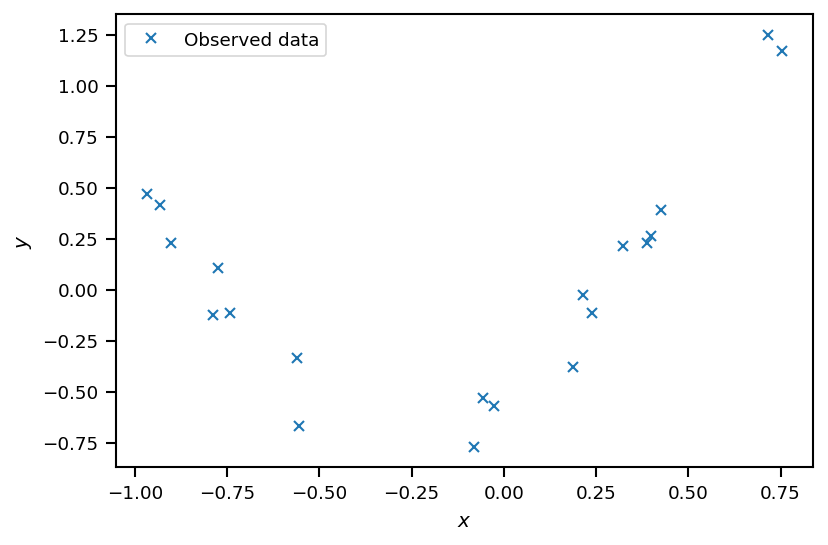

In [33]:
# How many observations we have
num_obs = 20
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 1.0
w2_true = 2.0
sigma_true = 0.1
y = w0_true + w1_true * x + w2_true * x ** 2 + sigma_true * np.random.randn(num_obs)
# Let's plot the data
fig, ax = plt.subplots(dpi=150)
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

Let's also copy-paste the code for creating design matrices for the three generalized linear models we have considered so far:

In [34]:
def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

We are not going to implement the automatic relevance determination from scratch. Instead we are going to use the implementation in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html#sklearn.linear_model.ARDRegression).
Here is how you do it:

In [43]:
# Load the Bayesian linear regression class:
from sklearn.linear_model import ARDRegression
# Select polynomial degree and get design matrix
degree = 16
# Build the design matrix
Phi = get_polynomial_design_matrix(x[:, None], degree)
# Do not normalize. ARDRegression seems to have a bug when you do.
model = ARDRegression(normalize=False, fit_intercept=False,
                      threshold_lambda=np.inf).fit(Phi, y)

Here is how you can get the noise variance:

In [44]:
# Sklearn optimizes the precision of the noise which is the inverse of the variance.
# It calls it alpha_.
sigma = np.sqrt(1.0 / model.alpha_)
print('sigma = {0:1.2f}'.format(sigma))

sigma = 0.12


Here is how you can get the precision corresponding to each weight.
Remember, that very high precision means that the corresponding basis function can be safely removed from your model.

[4.02807765e+00 7.24681703e-01 2.70714759e-01 5.24031645e+00
 9.61709308e+02 1.59183224e+03 1.33345254e+03 1.82309259e+03
 1.57515209e+03 1.57868174e+03 1.70408968e+03 1.91289898e+03
 1.75889037e+03 1.83197860e+03 1.75823701e+03 1.72857710e+03
 1.69881067e+03]


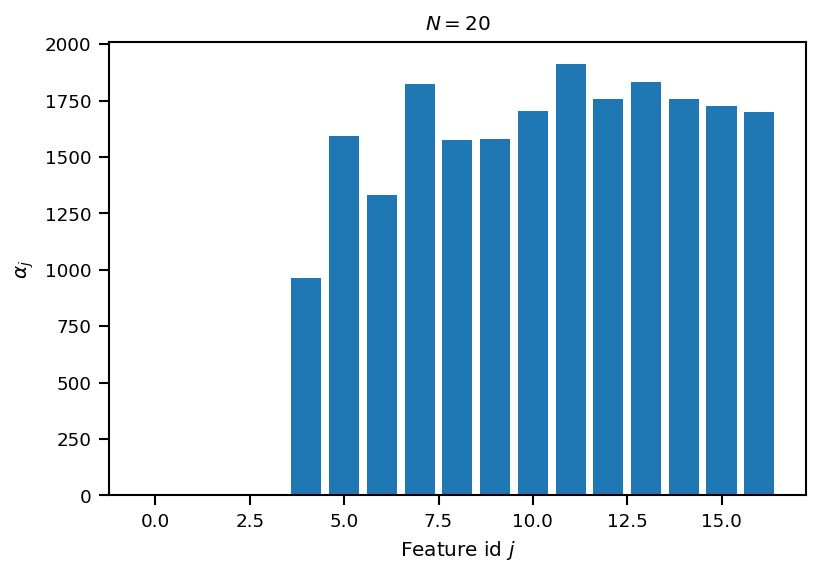

In [45]:
# Sklearn optimizes calls our alpha lambda_:
alpha = model.lambda_
print(alpha)
fig, ax = plt.subplots(dpi=150)
ax.bar(np.arange(degree+1), alpha)
ax.set_xlabel('Feature id $j$')
ax.set_ylabel(r'$\alpha_j$')
ax.set_title('$N={0:d}$'.format(num_obs));

We see that ARD tells us that we don't have to include the 4th, 5th, and 6th degree monomials.

Now, let's get the postserior mean of the weights.
Notice that the weights corresponding to 4th, 5th, and 6th degree polynomials are very close to zero:

In [46]:
# The posterior mean of the weights is here (this is for the normalized features, however)
m_norm = model.coef_
print(m_norm)

[-4.96379116e-01  1.16824772e+00  1.91795502e+00 -3.81421924e-01
 -1.56521592e-03 -4.71777169e-04 -1.39518219e-03  1.43641143e-04
 -1.17871427e-03  5.24280495e-04 -1.02461073e-03  5.70939581e-04
 -9.10328726e-04  6.45301160e-04 -8.25645878e-04  6.81616123e-04
 -7.71437496e-04]


And here is the posterior covariance of the weights:

In [47]:
# The posterior covariance matrix for the weights is here (also for the normalized features)
S_norm = model.sigma_
print(S_norm)

[[ 1.87736562e-03 -1.16789796e-03 -3.75245094e-03  5.40183076e-04
   6.65307513e-05 -1.72103275e-05  5.14604705e-05 -2.31873454e-05
   4.04939551e-05 -2.98686271e-05  3.38359998e-05 -2.46793164e-05
   2.94915048e-05 -2.46106346e-05  2.65595748e-05 -2.43362385e-05
   2.47930159e-05]
 [-1.16789796e-03  1.50721647e-02 -3.79793646e-04 -2.27136367e-02
  -1.25146808e-04  6.92997444e-05 -1.42652147e-04  1.01524106e-04
  -1.36235335e-04  1.31250281e-04 -1.27073565e-04  1.08765405e-04
  -1.18458746e-04  1.09013598e-04 -1.11388889e-04  1.08465223e-04
  -1.07028625e-04]
 [-3.75245094e-03 -3.79793646e-04  1.57198364e-02  8.64819762e-03
  -7.19993001e-04  7.93066267e-05 -3.60942595e-04  8.88422613e-05
  -2.22354409e-04  1.07520161e-04 -1.56967570e-04  8.57056010e-05
  -1.21168406e-04  8.31718893e-05 -9.99175679e-05  8.03645553e-05
  -8.74725692e-05]
 [ 5.40183076e-04 -2.27136367e-02  8.64819762e-03  4.56035689e-02
   3.38800097e-04 -5.03555360e-04  3.65857097e-04 -4.04550301e-04
   3.42732086e-04 -

Now, let's plot the marginal posterior for each weight.
Notice how 4th, 5th, and 6th are centered at zero.

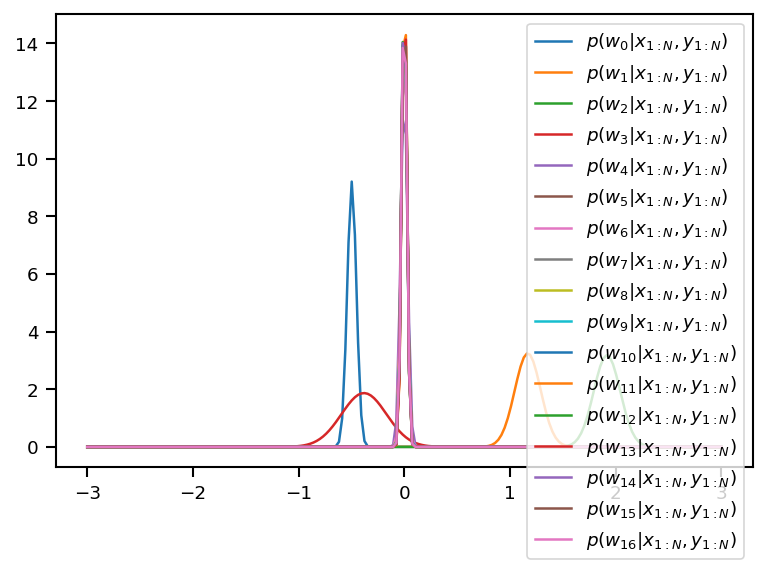

In [48]:
import scipy.stats as st
# plot the posterior of all the weights
ww = np.linspace(-3.0, 3.0, 200)
fig, ax = plt.subplots(dpi=150)
for j in range(S_norm.shape[0]):
    wj_post = st.norm(loc=m_norm[j], scale=np.sqrt(S_norm[j, j]))
    ax.plot(ww, wj_post.pdf(ww), label=r'$p(w_{{{0:d}}}|x_{{1:N}}, y_{{1:N}})$'.format(j))
plt.legend(loc='best')

Let's now plot the posterior predictive separating aleatory and epistemic uncertainty:

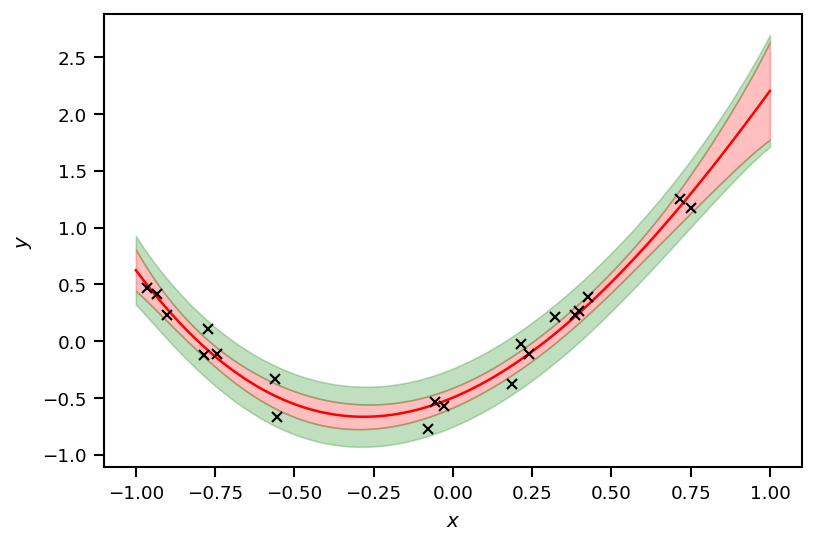

In [49]:
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy_mean, yy_measured_std = model.predict(Phi_xx, return_std=True)
yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
fig, ax = plt.subplots(dpi=150)
ax.plot(xx, yy_mean, 'r')
# Epistemic lower bound
yy_le = yy_mean - 2.0 * yy_std
# Epistemic upper bound
yy_ue = yy_mean + 2.0 * yy_std
# Epistemic + aleatory lower bound
yy_lae = yy_mean - 2.0 * yy_measured_std
# Episemic + aleatory upper bound
yy_uae = yy_mean + 2.0 * yy_measured_std
ax.fill_between(xx, yy_le, yy_ue, color='red', alpha=0.25)
ax.fill_between(xx, yy_lae, yy_le, color='green', alpha=0.25)
ax.fill_between(xx, yy_ue, yy_uae, color='green', alpha=0.25)
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# overlay the true 
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

Let's take samples from the posterior:

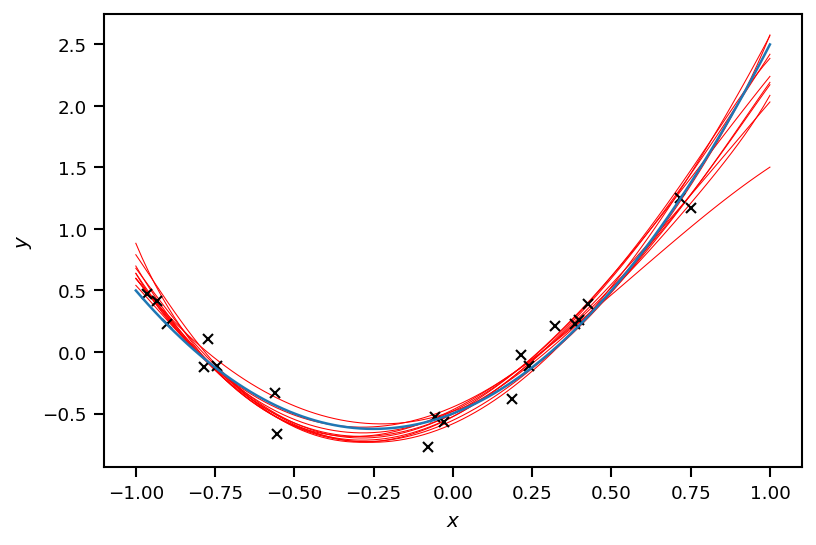

In [50]:
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
# These are the unscaled features:
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)

# Now let's put together the posterior of the weights
import scipy.stats as st
w_post = st.multivariate_normal(mean=m_norm, cov=S_norm)
# If you get an error because the covariance matrix is singular, add something small
# the diagonal. The covariance matrix is always positive definite (and non-singular)
# but it may have eigenvalues that are so close to zero that the numerical algorithms find
# them to be slightly negative. This is an artifact of the floating point precision.
# Comment the line above and uncomment the line below to fix the problem.
# w_post = st.multivariate_normal(mean=m_norm, cov=S_norm + 1e-6 * np.eye(S_norm.shape[0]))

# Let's take a plot some posterior samples
fig, ax = plt.subplots(dpi=150)
for _ in range(10):
    w_sample = w_post.rvs()
    yy_sample = np.dot(Phi_xx, w_sample)
    ax.plot(xx, yy_sample, 'r', lw=0.5)
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# overlay the true 
ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

### Questions
+ Rerun with a smaller number of observations, say $N=5$. What happens to the epistemic uncertainty?
+ Rerun with a very small number of observations, say $N=2$. What happens then? (The step that samples from the posterior may not work as expected. Please look at the comment in the code to fix the problem.)
+ Rerun everything with a higher degree polynomial. Try $4$, $8$, and $16$.
Notice that the fit remains good in between but the way you extrapolate changes. Why?